# Book Recommendation System Using KNN
***

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## Load in Data

In [2]:
df_books = pd.read_csv(
    'data/BX-Books.csv',
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    'data/BX-Book-Ratings.csv',
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

df_users = pd.read_csv(
    'data/BX-Users.csv',
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'location', 'age'],
    usecols=['user', 'location', 'age'],
    dtype={'user': 'int32', 'location': 'str', 'age': 'float32'})

In [3]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [4]:
df_ratings.head()
df_ratings.describe()

,user,rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [5]:
df_users.head()

,user,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


## Analyze Data

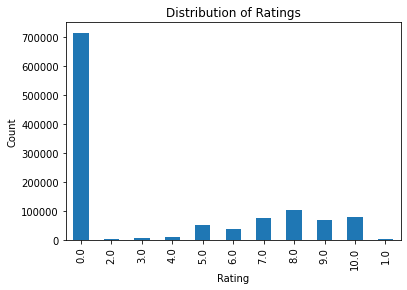

In [6]:
df_ratings.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('images/ratings_bar.png', bbox_inches='tight')
plt.show()

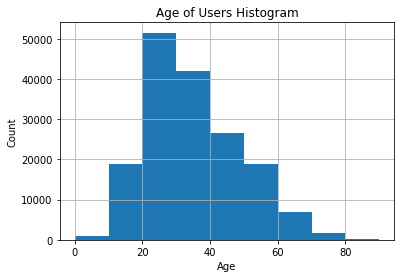

In [7]:
df_users.age.hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.title('Age of Users Histogram')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('images/age_bar.png')
plt.show()

In [8]:
average_ratings = df_ratings.drop(columns='user')
average_ratings = average_ratings.rename(columns={"rating":"avg_rating"})
average_ratings.head()

,isbn,avg_rating
0,034545104X,0.0
1,0155061224,5.0
2,0446520802,0.0
3,052165615X,3.0
4,0521795028,6.0


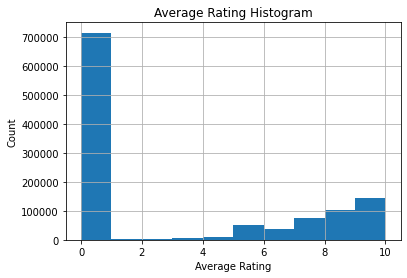

In [9]:
average_ratings.hist(bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.title("Average Rating Histogram")
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.savefig('images/avg_ratings.png')
plt.show()

/Users/thomas/Documents/Github/BookRecommender/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


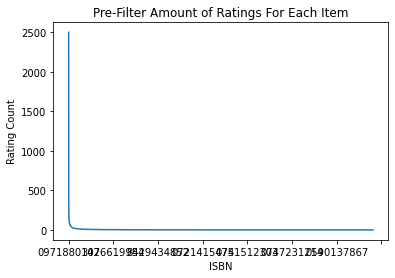

In [10]:
df_ratings['isbn'].value_counts().plot()
plt.title("Pre-Filter Amount of Ratings For Each Item")
plt.xlabel("ISBN")
plt.ylabel("Rating Count")
plt.savefig('images/pre_filter_review_count.png')
plt.show()

We can see that most of the records have less then 100 ratings. These aren't really helpful to the model so we'll drop them.

In [11]:
df_ratings['isbn'].value_counts().describe()

count    340556.000000
mean          3.376185
std          12.436252
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2502.000000
Name: isbn, dtype: float64

Gets the amount of ratings for each unique isbn. 

In [12]:
df_counts = df_ratings['isbn'].value_counts()
df_counts = df_counts.to_frame()
df_counts = df_counts.rename(columns={'isbn': 'rating_count'})
df_counts.head()

,rating_count
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


Filters the rows to the books with more than 250 reviews.

In [13]:
to_drop = df_counts[df_counts['rating_count'] <= 250].index
df_counts.drop(to_drop, inplace=True)
df_counts.head()

,rating_count
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723


In [14]:
df_ratings = df_ratings[df_ratings['isbn'].isin(df_counts.index)]
df_ratings.describe()

,user,rating
count,48658.000000,48658.000000
mean,139446.556311,3.380492
std,80413.345508,4.046078
min,9.000000,0.000000
25%,69355.000000,0.000000
50%,138189.000000,0.000000
75%,210485.000000,8.000000
max,278844.000000,10.000000


/Users/thomas/Documents/Github/BookRecommender/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


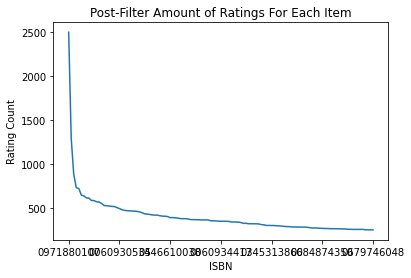

In [15]:
df_ratings['isbn'].value_counts().plot()
plt.title("Post-Filter Amount of Ratings For Each Item")
plt.xlabel("ISBN")
plt.ylabel("Rating Count")
plt.savefig('images/post_filter_review_count.png')
plt.show()

In [16]:
df_ratings.head()

,user,isbn,rating
84,276788,043935806X,7.0
173,276847,0446364193,0.0
426,276925,0316666343,0.0
429,276925,0385504209,8.0
453,276925,0804106304,0.0


## Model Building

Since the dataset is so large I don't want to feed it straight into the model. So I converted into a spicy sparse matrix. 

In [17]:
df_features = df_ratings.pivot(index='isbn', columns='user', values='rating').fillna(0)
mat_features = csr_matrix(df_features.values)

In [18]:
knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'auto')

In [19]:
knn_model.fit(mat_features)
print(knn_model)

NearestNeighbors(metric='cosine')


In [20]:
query = np.random.choice(df_features.shape[0])
distances, indices = knn_model.kneighbors(df_features.iloc[query, :].values.reshape(-1, 18356), n_neighbors = 6)
df_features.index[query]

'0684872153'

In [21]:
searching = []
found_isbns = []
isbns_distances = []
for i in range(0, len(distances.flatten())):
    if i == 0:
        searching.append(df_features.index[indices.flatten()[i]])
        print('Recommendations for {0}:\n'.format(df_features.index[query]))
    else:
        found_isbns.append(df_features.index[indices.flatten()[i]])
        isbns_distances.append(distances.flatten()[i])
        print('{0}: {1}, with distance of {2}:'.format(i, df_features.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 0684872153:

1: 0440224675, with distance of 0.9545705318450928:
2: 044023722X, with distance of 0.9556370377540588:
3: 0316096199, with distance of 0.9577246904373169:
4: 0060987103, with distance of 0.9578819274902344:
5: 0385720106, with distance of 0.9581356048583984:


In [22]:
results = df_books[df_books['isbn'].isin(found_isbns)]
searching_book = df_books[df_books['isbn'].isin(searching)]
data = {'isbn': found_isbns, 'distances': isbns_distances}
dist_dict = pd.DataFrame.from_dict(data)
results = pd.merge(dist_dict, results, on='isbn')

In [23]:
searching_book.head()

,isbn,title,author
4578,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt


In [24]:
results.head()

,isbn,distances,title,author
0,0440224675,0.954571,Hannibal,Thomas Harris
1,044023722X,0.955637,A Painted House,John Grisham
2,0316096199,0.957725,Lucky : A Memoir,Alice Sebold
3,0060987103,0.957882,Wicked: The Life and Times of the Wicked Witch...,Gregory Maguire
4,0385720106,0.958136,A Map of the World,Jane Hamilton
